In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils import spectral_norm
import torchvision
from torchvision.utils import make_grid

import cv2
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)

from pathlib import Path
from tqdm import tqdm
import os

The data loading cells are taken from this gihub repo. And I highly recommend anyone who deals with datasets like CityScapes, COCO, Pascal. [link](https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/loader/camvid_loader.py)

In [2]:
def recursive_glob(rootdir=".", suffix=""):
    """Performs recursive glob with given suffix and rootdir
        :param rootdir is the root directory
        :param suffix is the suffix to be searched
    """
    return [
        os.path.join(looproot, filename)
        for looproot, _, filenames in os.walk(rootdir)
        for filename in filenames
        if filename.endswith(suffix)
    ]

In [3]:
class CityScapesDataset(Dataset):
    colors = [  # [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]
    
    label_colours = dict(zip(range(19), colors))
    
    def __init__(self, 
                 root, 
                 split='train', 
                 is_transform=False,
                 img_size=(256, 256),
                 img_norm=True,
                 test_mode=False):
        self.root = root
        self.split = split
        self.is_transform = is_transform
        self.img_norm = img_norm
        self.n_classes = 19
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.files = {}
        
        self.images_base = os.path.join(self.root, "leftImg8bit", self.split)
        self.annotations_base = os.path.join(self.root, "gtFine", self.split)
        
        self.files[split] = recursive_glob(rootdir=self.images_base, suffix=".png")

        self.void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
        self.valid_classes = [
            7,
            8,
            11,
            12,
            13,
            17,
            19,
            20,
            21,
            22,
            23,
            24,
            25,
            26,
            27,
            28,
            31,
            32,
            33,
        ]
        self.class_names = [
            "unlabelled",
            "road",
            "sidewalk",
            "building",
            "wall",
            "fence",
            "pole",
            "traffic_light",
            "traffic_sign",
            "vegetation",
            "terrain",
            "sky",
            "person",
            "rider",
            "car",
            "truck",
            "bus",
            "train",
            "motorcycle",
            "bicycle",
        ]

        self.ignore_index = 250
        self.class_map = dict(zip(self.valid_classes, range(19)))
        
        if not self.files[split]:
            raise Exception("No files for split=[%s] found in %s" % (split, self.images_base))

        print("Found %d %s images" % (len(self.files[split]), split))
        
    def __len__(self):
        return len(self.files[self.split])
    
    def __getitem__(self, index):
        img_path = self.files[self.split][index].rstrip()
        lbl_path = os.path.join(
            self.annotations_base,
            img_path.split(os.sep)[-2],
            os.path.basename(img_path)[:-15] + "gtFine_labelIds.png",
        )
        
        img = imread(img_path)
        img = np.array(img, dtype=np.uint8)

        lbl = imread(lbl_path)
        lbl = self.encode_segmap(np.array(lbl, dtype=np.uint8))
        
        if self.is_transform:
            img, lbl = self.transform(img, lbl)
        lbl = lbl.unsqueeze(0)
        lbl = lbl.float()
        return img, lbl
    
    def decode_segmap(self, temp):
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = self.label_colours[l][0]
            g[temp == l] = self.label_colours[l][1]
            b[temp == l] = self.label_colours[l][2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb

    def encode_segmap(self, mask):
        # Put all void classes to zero
        for _voidc in self.void_classes:
            mask[mask == _voidc] = self.ignore_index
        for _validc in self.valid_classes:
            mask[mask == _validc] = self.class_map[_validc]
        return mask
    
    def transform(self, img, lbl):
        """transform
        :param img:
        :param lbl:
        """
        img = cv2.resize(img, (self.img_size[0], self.img_size[1]))
        # img = m.imresize(img, (self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float64)
        if self.img_norm:
            # Resize scales images from 0 to 255, thus we need
            # to divide by 255.0
            img = img.astype(float) / 255.0
        # NHWC -> NCHW
        img = img.transpose(2, 0, 1)

        classes = np.unique(lbl)
        lbl = lbl.astype(float)
        # lbl = m.imresize(lbl, (self.img_size[0], self.img_size[1]), "nearest", mode="F")
        lbl = cv2.resize(lbl, (self.img_size[0], self.img_size[1]), interpolation=cv2.INTER_NEAREST)
        lbl = lbl.astype(int)

        if not np.all(classes == np.unique(lbl)):
            print("WARN: resizing labels yielded fewer classes")

        if not np.all(np.unique(lbl[lbl != self.ignore_index]) < self.n_classes):
            print("after det", classes, np.unique(lbl))
            raise ValueError("Segmentation map contained invalid class values")

        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()
        
        return img, lbl

In [4]:
# I create two datasets one for train and other for val
path = '../../Data/City Scape Dataset/'
dataset = {
    x: CityScapesDataset(path, split=x, is_transform=True) for x in ['train', 'val']
}

Found 2975 train images
Found 500 val images


In [5]:
data = {
    x: DataLoader(dataset[x], 
                  batch_size=4, 
                  shuffle=True, 
                  num_workers=0) for x in ['train', 'val']
}

In [6]:
# After creating dataloader, you should always check if things are working fine
iterator = iter(data['train'])

In [7]:
img, seg = next(iterator)

In [8]:
img.size()

torch.Size([4, 3, 256, 256])

In [9]:
seg.size()

torch.Size([4, 1, 256, 256])

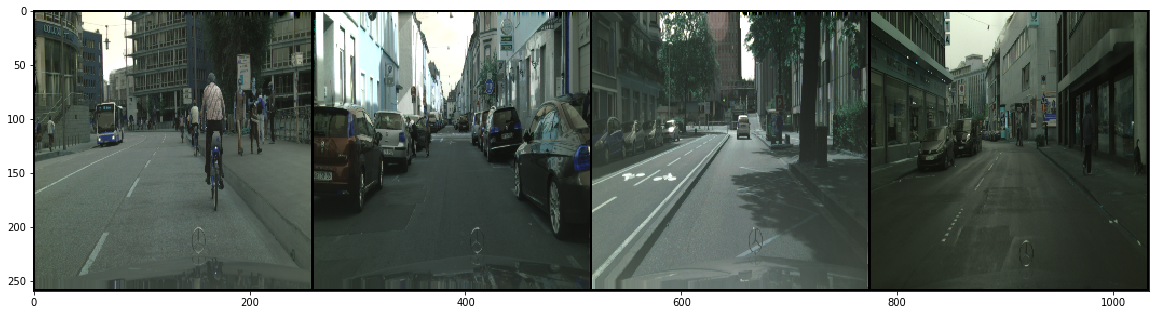

In [10]:
plt.rcParams['figure.figsize'] = (20, 12)

# Plotting functions for true image
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.pause(0.001)
    
grid_img = make_grid(img, nrow=4)
imshow(grid_img)

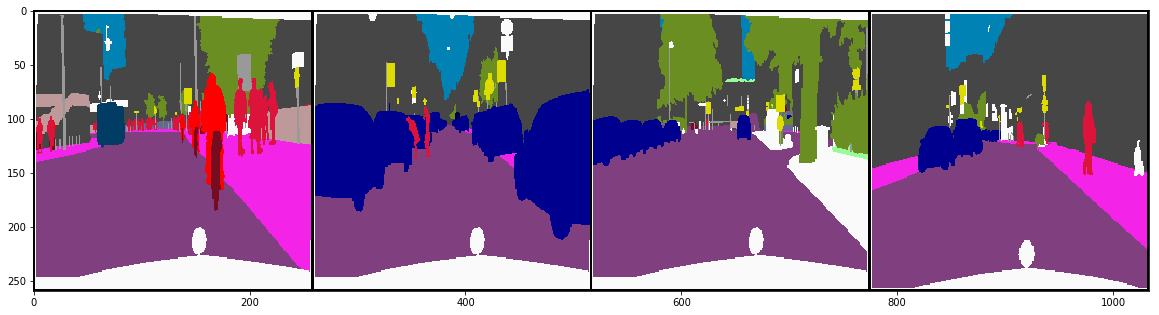

In [11]:
segmap = torch.zeros(seg.size(0), 3, seg.size(2), seg.size(3))
# Plotting function for segmentation task
for i, a in enumerate(seg):
    image = a.squeeze()
    image = image.numpy()
    image = dataset['train'].decode_segmap(image)
    image = image.transpose((2, 0, 1))
    image = torch.from_numpy(image)
    segmap[i] = image
    
def imshow(image):
    image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image)
    plt.pause(0.001)
    
grid_img = make_grid(segmap, nrow=4)
imshow(grid_img)

## SPADE Normalization Layer
The main SPADE cell which is the building block for the whole architecture.

| <img src="Images/spade_cell.png">

In [12]:
class SPADE(nn.Module):
    def __init__(self, k):
        # Explanation of the conv layer attributes
        # 1. kernel_size = (3, 3). In the paper they experimented and chose 3x3.
        # 5x5 gives similiar performance
        # 2. Padding=1 is used to keep the size of the feature maps same (i.e if
        # input is of size (128, 128, 3) then after conv layer it will still
        # be (128, 128, 3))
        # 3. The in_channels=1 for self.conv because the seg map has 1 dim
        # 4 The mid_channels=128 From the paper
        # 5. k -> The number of channels that the activation map has (in our case
        # the number of channels that x has in the forward)
        super().__init__()
        self.conv = spectral_norm(nn.Conv2d(1, 128, kernel_size=(3, 3), padding=1))
        self.conv_gamma = spectral_norm(nn.Conv2d(128, k, kernel_size=(3, 3), padding=1))
        self.conv_beta = spectral_norm(nn.Conv2d(128, k, kernel_size=(3, 3), padding=1))
    
    def forward(self, x, seg):
        # Store the sizes for easy reference
        N, C, H, W = x.size()
        
        # Apply Normalization for the input activations i.e. x
        # To compute the sum faster I combine the height and width, as I can
        # access the last dim easily with dim=-1
        
        # Compute the mean and std. Direct formulas are used. One modification
        # that you can do here, is to store the running mean and std as in the
        # pytorch BatchNorm layer. Implementation of that is also, easy a quick
        # look at the batchnorm source code would be sufficient.
        sum_channel = torch.sum(x.reshape(N, C, H*W), dim=-1)
        mean = sum_channel / (N*H*W)
        std = torch.sqrt((sum_channel**2 - mean**2) / (N*H*W))
        
        # Pytorch broadcasting words from the tail side. So for example if I have
        # two inputs of dim (4, 3) and (4, 3, 256, 256). PyTorch would expand the 
        # first input of (4, 3) dim as (1, 1, 4, 3). So to prevent it and use 
        # torch broadcasting I use unsqueeze twice to make it (4, 3, 1, 1)
        mean = torch.unsqueeze(torch.unsqueeze(mean, -1), -1)
        std = torch.unsqueeze(torch.unsqueeze(std, -1), -1)
        x = (x - mean)/std
        
        # Apply conv layers to the segmentation map
        # The first step is to make the segmentation map the same size as activations
        # i.e x. We will use nearest-neighbour upsampling, as we don't want to introduce
        # new terms in the segmentation map (remember every value in the segmentation map
        # corresponds to a class and we cannot create new values as they would not 
        # correspond to any class). nearest-neighbour simply repeats the neighbouring
        # values, thus not introducing new terms.
        seg = F.interpolate(seg, size=(H, W), mode='nearest')
        seg = F.relu(self.conv(seg))
        seg_gamma = self.conv_gamma(seg)
        seg_beta = self.conv_beta(seg)
        
        # Apply the rescaling
        x = torch.matmul(seg_gamma, x) + seg_beta
        
        return x

In [13]:
# Some testing code to see we get desired output
spade = SPADE(3)
out = spade(img, seg)
out.size()

torch.Size([4, 3, 256, 256])

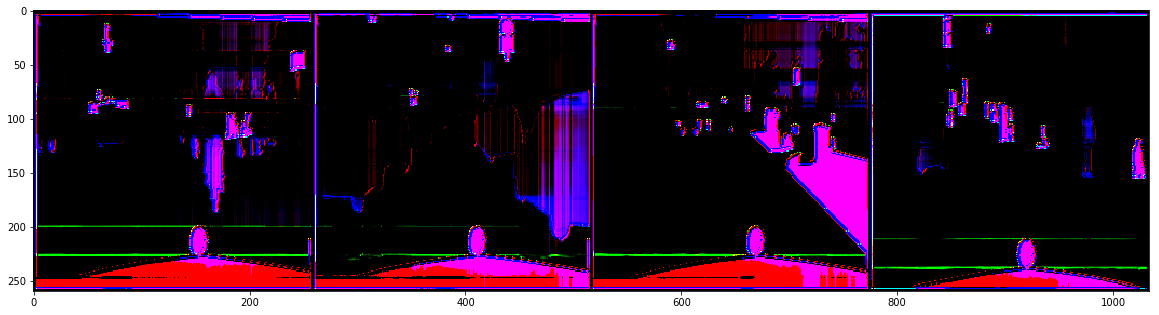

In [14]:
# Plot the resutls for fun
def imshow(img):
    img = img.detach().numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.pause(0.001)

grid_img = make_grid(out, nrow=4)
imshow(grid_img)

## SPDAE ResBlk
ResBlk combines the SPADE cells that we defined above. And in our generator we would use these ResBlk's.

<img src="Images/spade_resblk.png">

In [15]:
class SPADEResBlk(nn.Module):
    def __init__(self, k, skip=False):
        # I do not have different channels in my implementation, but I have provided
        # the code that you can use to modify the ResBlk to include that also
        super().__init__()
        self.spade1 = SPADE(k)
        self.conv1 = nn.Conv2d(k, k, kernel_size=(3,3), padding=1, bias=False)
        self.spade2 = SPADE(k)
        self.conv2 = nn.Conv2d(k, k, kernel_size=(3,3), padding=1, bias=False)
        
        # self.skip = skip
        # if self.skip:
        #     self.skip_spade = SPADE(k)
            
    def forward(self, x, seg):
        x_skip = x
        x = F.relu(self.spade1(x, seg))
        x = self.conv1(x)
        x = F.relu(self.spade2(x, seg))
        x = self.conv2(x)
        
        # if self.skip:
        #     x_skip = self.skip_spade(x_skip, seg)
            
        return x_skip + x

In [16]:
# Check the output is of correct size
spade = SPADEResBlk(3)
out = spade(img, seg)
out.size()

torch.Size([4, 3, 256, 256])

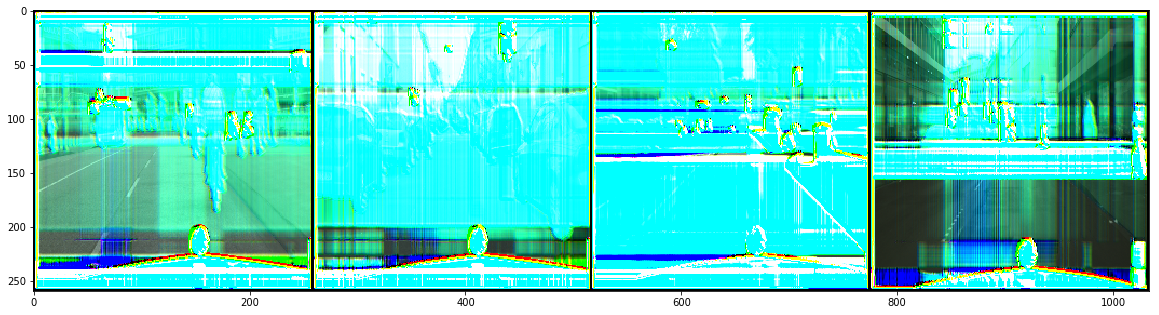

In [17]:
# PLot for fun
grid_img = make_grid(out, nrow=4)
imshow(grid_img)

## SPADE Generator
You will pass pass either random noise to the generator or image features from an encoder. If you pass image features, then you will see results similiar to style transfer, where the style from the image would be taken up in the image generated for the image generated for the segmentation map. To get the image features, we would design an encoder.

<img src="Images/generator.png">

In [17]:
# This is a literal implementation of the model presented in the paper. I am limited by my 
# GPU ram of 4GB, so I would not be able to do 
class SPADEGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(256, 16384)
        self.spade_resblk1 = SPADEResBlk(1024)
        self.spade_resblk2 = SPADEResBlk(1024)
        self.spade_resblk3 = SPADEResBlk(1024)
        self.spade_resblk4 = SPADEResBlk(512)
        self.spade_resblk5 = SPADEResBlk(256)
        self.spade_resblk6 = SPADEResBlk(128)
        self.spade_resblk7 = SPADEResBlk(64)
        self.conv = spectral_norm(nn.Conv2d(64, 3, kernel_size=(3,3), padding=1))
        
    def forward(self, x, seg):
        b, c, h, w = seg.size()
        x = self.linear(x)
        x = x.view(b, 512, 4, 4)
        
        x = F.interpolate(self.spade_resblk1(x, seg), size=(2*h, 2*w), mode='nearest')
        x = F.interpolate(self.spade_resblk2(x, seg), size=(4*h, 4*w), mode='nearest')
        x = F.interpolate(self.spade_resblk3(x, seg), size=(8*h, 8*w), mode='nearest')
        x = F.interpolate(self.spade_resblk4(x, seg), size=(16*h, 16*w), mode='nearest')
        x = F.interpolate(self.spade_resblk5(x, seg), size=(32*h, 32*w), mode='nearest')
        x = F.interpolate(self.spade_resblk6(x, seg), size=(64*h, 64*w), mode='nearest')
        x = F.interpolate(self.spade_resblk7(x, seg), size=(128*h, 128*w), mode='nearest')
        
        x = F.tanh(self.conv(x))
        
        return x

## Image Encoder
In case you don't want to pass random noise to the generator

<img src="Images/encoder.png">

In [36]:
def conv_inst_lrelu(in_chan, out_chan):
    return nn.Sequential(
        nn.Conv2d(in_chan, out_chan, kernel_size=(3,3), stride=2, bias=False, padding=1),
        nn.InstanceNorm2d(out_chan),
        nn.LeakyReLU(inplace=True)
    )

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = conv_inst_lrelu(3, 64)
        self.layer2 = conv_inst_lrelu(64, 128)
        self.layer3 = conv_inst_lrelu(128, 256)
        self.layer4 = conv_inst_lrelu(256, 512)
        self.layer5 = conv_inst_lrelu(512, 512)
        self.layer6 = conv_inst_lrelu(512, 512)
        self.linear_mean = nn.Linear(8192, 256)
        self.linear_var = nn.Linear(8192, 256)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = x.view(x.size(0), -1)
        return self.linear_mean(x), self.linear_var(x)

In [37]:
# Test encoder code
enc = Encoder()
mean, var = enc(img)
mean.size(), var.size()

(torch.Size([4, 256]), torch.Size([4, 256]))

In [29]:
8192*4

32768

## Discriminator

<img src="Images/discriminator.png">

In [52]:
def custom_model1(in_chan, out_chan):
    return nn.Sequential(
        spectral_norm(nn.Conv2d(in_chan, out_chan, kernel_size=(4,4), stride=2, padding=1, bias=False)),
        nn.LeakyReLU(inplace=True)
    )

def custom_model2(in_chan, out_chan, stride=2):
    return nn.Sequential(
        spectral_norm(nn.Conv2d(in_chan, out_chan, kernel_size=(4,4), stride=stride, padding=1, bias=False)),
        nn.InstanceNorm2d(out_chan),
        nn.LeakyReLU(inplace=True)
    )

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = custom_model1(4, 64)
        self.layer2 = custom_model2(64, 128)
        self.layer3 = custom_model2(128, 256)
        self.layer4 = custom_model2(256, 512, stride=1)
        self.inst_norm = nn.InstanceNorm2d(512)
        self.conv = spectral_norm(nn.Conv2d(512, 1, kernel_size=(4,4), padding=1))
        
    def forward(self, img, seg):
        x = torch.cat((img, seg), dim=1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.leaky_relu(self.inst_norm(x))
        x = self.conv(x)
        return x

In [53]:
dis = Discriminator()
out = dis(img, seg)

In [51]:
out.size()

torch.Size([4, 1, 24, 24])